# Discriminative Visualization Demo - PittPatt Black Box

## Define Custom PittPatt Black Box Scoring Function

In [1]:
import os
import shutil
import subprocess
import skimage
import imageio
import numpy as np
import pandas as pd

# Utility function
def center_crop(im, size=224):
    # Crop out the center square region
    minDim = min(im.shape[:2])
    yx = (np.asarray(im.shape[:2]) - minDim) // 2
    im = im[yx[0]:yx[0] + minDim,
            yx[1]:yx[1] + minDim]
    
    # Resize
    imS = skimage.transform.resize(im, (size, size), preserve_range=True)
    imS = imS.astype(im.dtype)
    return imS

# PittPatt black box scoring function
def pittpatt_bb_fn(probes, gallery):
    # Setup directories
    pittpatt_data_dir = '../data/pittpatt_dataset'
    pittpatt_apps_root = '/proj/janus/phase4/PittPattApps'
    pittpatt_sdk_root = '/proj/janus/phase4/PittPattSDK'

    # Save probes to disk
    probes_dir = '{}/probes'.format(pittpatt_data_dir)
    if os.path.exists(probes_dir):
        shutil.rmtree(probes_dir)
    os.makedirs(probes_dir)
    probes_filename = '{}/probes.txt'.format(pittpatt_data_dir)
    probes_f = open(probes_filename, 'w')
    for idx, im in enumerate(probes):
        filename = '{}/probe_{:04d}.jpg'.format(probes_dir, idx)
        probes_f.write(filename + '\n')
        im_uint8 = (im / im.max() * 255).astype(np.uint8)
        imageio.imsave(filename, im_uint8)
    probes_f.close()

    # Save gallery to disk
    gallery_dir = '{}/gallery'.format(pittpatt_data_dir)
    if os.path.exists(gallery_dir):
        shutil.rmtree(gallery_dir)
    os.makedirs(gallery_dir)
    gallery_filename = '{}/gallery.txt'.format(pittpatt_data_dir)
    gallery_f = open(gallery_filename, 'w')

    for idx, im in enumerate(gallery):
        filename = '{}/gallery_{:04d}.jpg'.format(gallery_dir, idx)
        gallery_f.write(filename + '\n')

        if isinstance(im, str):
            im = imageio.imread(im)
            im = center_crop(im)
        im_uint8 = (im / im.max() * 255).astype(np.uint8)
        imageio.imsave(filename, im_uint8)
    gallery_f.close()

    # Call pittpatt to compute scores
    os.environ['LD_LIBRARY_PATH'] = pittpatt_sdk_root + '/pittpatt_sdk-5.2.2-linux-x86_64/lib/' # :' + janus_tne_root + '/lib/'
    pittpatt_bin = pittpatt_apps_root + '/bin/str_visualization'
    pittpatt_models_path = pittpatt_sdk_root + '/pittpatt_sdk-5.2.2-linux-x86_64/models'
    probe_filename = '{}/probe.png'.format(pittpatt_data_dir)
    ref_filename = '{}/ref.png'.format(pittpatt_data_dir)
    pittpatt_process = subprocess.Popen([pittpatt_bin, '-models', pittpatt_models_path, probe_filename, ref_filename, gallery_filename, probes_filename], env=os.environ)
    pittpatt_process.wait()
    
    # Read in results
    pittpatt_df = pd.read_csv('/tmp/comparisons.csv')
    pittpatt_scores = pittpatt_df.iloc[1:,1:].values

    # Extract scores
    scores = pittpatt_scores[:,1:]
    return scores

## Evaulate Contrastive Saliency Using PittPatt Black Box

### Setup Dataset

In [2]:
ref = '../data/pittpatt_dataset/ref.png'
probe = '../data/pittpatt_dataset/probe.png'
gallery = '../data/pittpatt_dataset/gallery.png'

 ### Display Reference, Probe, and Non-Mate Gallery Images

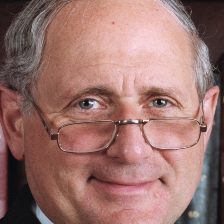

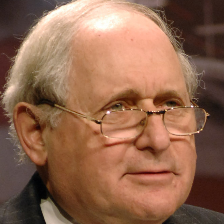

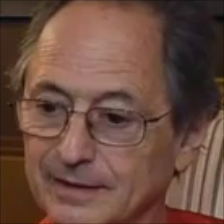

In [3]:
from IPython.display import Image, display

display(Image(ref))
display(Image(probe))
display(Image(gallery))

### Run Evaluation

In [4]:
import warnings
warnings.filterwarnings('ignore')
import xfr.models.blackbox as bb

strise = bb.STRise(probe=probe,
                   refs=[ref],
                   gallery=[gallery],
                   black_box_fn=pittpatt_bb_fn,
                   num_masks=1625)
strise.evaluate()

1/5 Computing prior...
2/5 Generating masks...
3/5 Applying masks...
4/5 Scoring masks...
5/5 Computing saliency map...
Finished!


### Display Contrastive Saliency Map

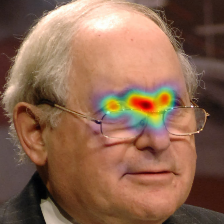

In [5]:
import PIL.Image
from xfr.show import blend_saliency_map

overlay = blend_saliency_map(strise.probe/255.0, strise.saliency_map)
PIL.Image.fromarray(np.uint8(255*overlay))